- Intructions on this Repo
1. Heap size error run this command line before run jupyter notebook on command line

export PYSPARK_SUBMIT_ARGS=' --conf spark.sql.shuffle.partitions=700 --conf spark.default.parallelism=700 --driver-memory 30g --driver-cores 6 --executor-memory 30g --executor-cores 6 pyspark-shell'

2. ERROR PythonRunner: Python worker exited unexpectedly (crashed) java.net.SocketException: Connection reset

Try to run several times

## Demand Forecasting

The objective of this notebook is to illuate how we might leverage the Apache Spark - the efficient distribution of the work required to generate hundreds of thousands or even millions of ML models in a timely manner and FBProphet - popular library for demanding forecasting.

NOTE: The original notebook utilized the DataBricks and DataLakes. In this notebook, I will use my Spark SQL and localhost storage to emulate the orginal notebook 

### Exploring Data
- Source: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

A relatively simple and clean dataset, given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores. 

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? 



#### Import Data from local to sql database
- use pyspark to import data to sql database, to work similarly to DataBricks notebook

In [1]:
#libraries
import pandas as pd
import numpy as np

#### Create SQL databse using Pyspark


In [2]:
#libraries
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
print(f"Pyspark Version: {pyspark.__version__}")

Pyspark Version: 3.3.0


In [3]:
#Create a spark Context class
sc = SparkContext()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/15 20:47:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Create spark session
spark = SparkSession.builder.master('local[*]').\
            config('spark.sql.debug.maxToStringFields', '100').\
            appName("Time Serries Forecasting").getOrCreate()

In [27]:
#read the training data into a dataframe, and convert to datatype accordingly
#library
from pyspark.sql.types import *

#structure of the training dataset
train_schema = StructType([
    StructField('date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('sales', IntegerType())
])

spdf_data = spark.read.csv('./Data/train.csv', header=True, schema=train_schema)

In [28]:
spdf_data.printSchema()

root
 |-- date: date (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)



In [29]:
spdf_data.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows



In [30]:
#make the temporary view table
spdf_data.createOrReplaceTempView('train')

##### General annual trends and seasonality in unit sales
NOTE: DataBricks sql is able to visuallize immediately with sql queries in notebook cells, on Jupyter notebook we will create dataframe and visuallize using python visuallize libraries

In [31]:
##load sparksql magic to run sql queries in notebook cell
%load_ext sparksql_magic

The sparksql_magic extension is already loaded. To reload it, use:
  %reload_ext sparksql_magic


##### Plot the annual trending 

In [32]:
%%sparksql
SELECT year(date) as year,
        sum(sales) as sales 
    FROM train 
    GROUP BY year(date) 
    ORDER BY year;

year,sales
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740


In [33]:
#collect data
query_annual_trending ='\
    SELECT year(date) as year,\
            sum(sales) as sales \
    FROM train \
    GROUP BY year(date) \
    ORDER BY year;'
collected_annual_trending = spark.sql(query_annual_trending).collect()

In [34]:
collected_annual_trending

[Row(year=2013, sales=7941243),
 Row(year=2014, sales=9135482),
 Row(year=2015, sales=9536887),
 Row(year=2016, sales=10357160),
 Row(year=2017, sales=10733740)]

In [45]:
#convert to dataframe for plotting
df_annual_trending = pd.DataFrame(collected_annual_trending, columns=['year', 'million_sales'])
df_annual_trending['million_sales'] = df_annual_trending['million_sales'].apply(lambda x: x/10**6)

In [46]:
df_annual_trending

,year,million_sales
0,2013,7.941243
1,2014,9.135482
2,2015,9.536887
3,2016,10.357160
4,2017,10.733740


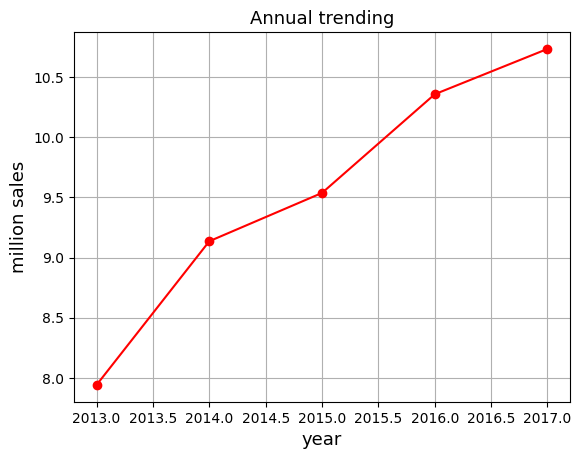

In [48]:
#plot
import matplotlib.pyplot as plt

plt.plot(df_annual_trending['year'], df_annual_trending['million_sales'], color='red', marker='o')
plt.title("Annual trending", fontsize=13)
plt.xlabel('year', fontsize=13)
plt.ylabel('million sales', fontsize=13)
plt.grid(True)
plt.show()

It is very clear growth from our annual trending chart in total sales across the stores. From this trend, we are able to expect our warehouse capacity to increase, and We might expect continued growth in few days, months.

##### Plotting Seasonality trend

In [49]:
%%sparksql
SELECT
    TRUNC(date, 'MM') as month,
    SUM(sales) as sales
FROM train
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

only showing top 20 row(s)


month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


In [52]:
#collect data
query_seasonality_trending ="\
    SELECT TRUNC(date, 'MM') as month,\
            sum(sales) as sales \
    FROM train \
    GROUP BY TRUNC(date, 'MM') \
    ORDER BY month;"
collected_seasonality_trending = spark.sql(query_seasonality_trending).collect()

In [54]:
collected_seasonality_trending[1:10]

[Row(month=datetime.date(2013, 2, 1), sales=459417),
 Row(month=datetime.date(2013, 3, 1), sales=617382),
 Row(month=datetime.date(2013, 4, 1), sales=682274),
 Row(month=datetime.date(2013, 5, 1), sales=763242),
 Row(month=datetime.date(2013, 6, 1), sales=795597),
 Row(month=datetime.date(2013, 7, 1), sales=855922),
 Row(month=datetime.date(2013, 8, 1), sales=766761),
 Row(month=datetime.date(2013, 9, 1), sales=689907),
 Row(month=datetime.date(2013, 10, 1), sales=656587)]

In [64]:
#convert to dataframe for plotting
df_seasonality_trending = pd.DataFrame(collected_seasonality_trending, columns=['month', 'thousand_sales'])
df_seasonality_trending['thousand_sales'] = df_seasonality_trending['thousand_sales'].apply(lambda x: x/1000)

<AxesSubplot:xlabel='month'>

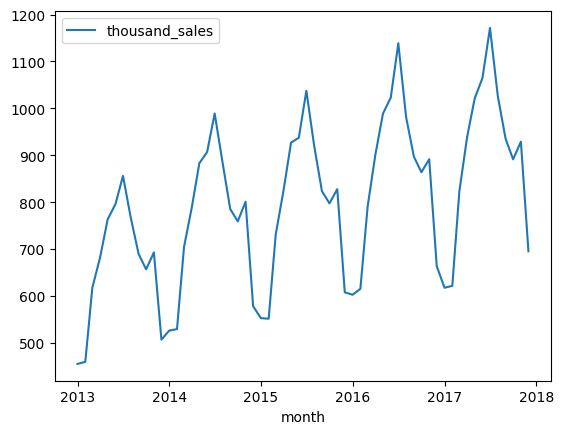

In [65]:
#plot
import matplotlib.pyplot as plt

##
plt.plot(df_seasonality_trending['month'], df_seasonality_trending['thousand_sales'], color='red', marker='o')
plt.title('Seasonality trending', fontsize=13)
plt.xlabel('')